In [4]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [87]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sb
from scipy import stats
from sklearn.decomposition import PCA
import scanpy
from anndata import AnnData
import umap
import anndata
from matplotlib.colors import LogNorm
from difflib import SequenceMatcher
from adjustText import adjust_text
import itertools
from sklearn.mixture import GaussianMixture
import matplotlib.scale as mscale
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker
from matplotlib import colors
import ast
import matplotlib.cm as cm
from scipy.stats import norm
import matplotlib.collections as mcoll
from Levenshtein import distance as levenshtein_distance

In [6]:
class SquareRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square root scale.
    """
 
    name = 'squareroot'
 
    def __init__(self, axis, **kwargs):
        # note in older versions of matplotlib (<3.1), this worked fine.
        # mscale.ScaleBase.__init__(self)

        # In newer versions (>=3.1), you also need to pass in `axis` as an arg
        mscale.ScaleBase.__init__(self, axis)
 
    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  vmin, vmax
 
    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform_non_affine(self, a): 
            return (np.abs(a)**0.7) * np.sign(a)
 
        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()
 
    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform(self, a):
            return
 
        def inverted(self):
            return SquareRootScale.SquareRootTransform()
 
    def get_transform(self):
        return self.SquareRootTransform()

mscale.register_scale(SquareRootScale)

In [7]:
class SquareScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square scale.
    """
 
    name = 'square'
 
    def __init__(self, axis, **kwargs):
        # note in older versions of matplotlib (<3.1), this worked fine.
        # mscale.ScaleBase.__init__(self)

        # In newer versions (>=3.1), you also need to pass in `axis` as an arg
        mscale.ScaleBase.__init__(self, axis)
 
    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())
 
    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  vmin, vmax
 
    class SquareTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform_non_affine(self, a): 
            return (np.abs(a)**2) * np.sign(a)
 
        def inverted(self):
            return SquareScale.InvertedSquareTransform()
 
    class InvertedSquareTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform(self, a):
            return
 
        def inverted(self):
            return SquareScale.SquareTransform()
 
    def get_transform(self):
        return self.SquareTransform()

mscale.register_scale(SquareScale)

In [8]:
def colorline(
        x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments


In [9]:
sys.path.append("/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/")

In [10]:
import rnaseq
importlib.reload(rnaseq)

<module 'rnaseq' from '/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/__init__.py'>

In [11]:
def hammingDist(str1, str2, fillchar = '-'):
    return sum([ch1 != ch2 for (ch1,ch2) in itertools.zip_longest(str1, str2, fillvalue = fillchar)])

In [12]:
def DFS(neighbors_mtx, component, barcode, visited):

    visited[barcode] = True
    component.append(barcode)
    
    neighbors = neighbors_mtx.index.values[neighbors_mtx[barcode] == 1]
    for neighbor in neighbors :
        if visited[neighbor][0] == False:
            component = DFS(neighbors_mtx, component, neighbor, visited)
    return component


def connectedComponents(neighbors_mtx) :
    
    barcodes = neighbors_mtx.index.values
    visited = pd.DataFrame([np.repeat(False, len(barcodes))], columns = barcodes, index = ["visited"])
    all_components = []

    for barcode in barcodes :
        if visited[barcode][0] == False:
            component = []
            all_components.append(DFS(neighbors_mtx, component, barcode, visited))
    
    i = np.argsort([len(c) for c in all_components])[::-1]
    
    return np.array(all_components, dtype = object)[i]

In [13]:
# def plot_errors(correction_dict, barcodes, weight_by_lib = True) :
#     nucleotides = ["A","T","G","C"]
#     substitutions = {f"{pos}{nt1}": {nt2 : 0 for nt2 in nucleotides} for pos in np.arange(1,13) for nt1 in nucleotides}


#     for barcode1 in correction_dict.keys() :
#         for barcode2 in correction_dict[barcode1] :
#             if barcode2 not in barcodes :
#                 continue
#             pos = [i for i in range(len(barcode1)) if barcode1[i] != barcode2[i]][0]
#             nt1 = list(barcode1)[pos]
#             nt2 = list(barcode2)[pos]
#             if weight_by_lib :
#                 substitutions[f"{pos+1}{nt1}"][nt2] += sc.obs["raw_cb_freq"].loc[barcode2]
#             else :
#                 substitutions[f"{pos+1}{nt1}"][nt2] += 1
    
#     counts = np.array([list(list(substitutions.values())[i].values()) for i in np.arange(48)])
#     fig, ax = plt.subplots(figsize=(5.5,2.5))
#     ax.set_prop_cycle('color', sb.color_palette("twilight_shifted", 4))
#     bottom = 0
#     for c in counts.T :
#         ax.bar(np.arange(48), c, width = 0.7, bottom = bottom)
#         bottom += c

#     ax.legend(labels = nucleotides)
#     plt.xticks(np.arange(48), labels = substitutions.keys(), rotation = 90)
#     plt.ylim(0,np.max(bottom)+np.max(bottom)/30)
#     plt.xlim(-1.5,48.5)
#     plt.tight_layout()

In [79]:
def plot_errors(errors, libs, neighbors_mtx, weight_by_lib = True) :
    
    nucleotides = ["A","T","G","C"]
    substitutions = {f"{pos}{nt1}": {nt2 : 0 for nt2 in nucleotides} for pos in np.arange(1,13) for nt1 in nucleotides}

              
    for barcode2 in errors :
        
        neighbors = neighbors_mtx.index.values[neighbors_mtx[barcode2] == 1]
        if len(neighbors) == 0 :
            continue
        nn_df = pd.DataFrame(np.array([libs.loc[neighbors].values.ravel()]).T, columns = ["lib"], index = neighbors)
        sorted_nn = nn_df.sort_values(by=["lib"], ascending=False).index.values
        barcode1 = sorted_nn[0]

        pos = [i for i in range(len(barcode1)) if barcode1[i] != barcode2[i]][0]
        nt1 = list(barcode1)[pos]
        nt2 = list(barcode2)[pos]
        if weight_by_lib :
            substitutions[f"{pos+1}{nt1}"][nt2] += libs.loc[barcode2]
        else :
            substitutions[f"{pos+1}{nt1}"][nt2] += 1
    
    counts = np.array([list(list(substitutions.values())[i].values()) for i in np.arange(48)])
    fig, ax = plt.subplots(figsize=(5.5,2.5))
    ax.set_prop_cycle('color', sb.color_palette("twilight_shifted", 4))
    bottom = 0
    for c in counts.T :
        ax.bar(np.arange(48), c, width = 0.7, bottom = bottom)
        bottom += c

    ax.legend(labels = nucleotides)
    plt.xticks(np.arange(48), labels = substitutions.keys(), rotation = 90)
    plt.ylim(0,np.max(bottom)+np.max(bottom)/30)
    plt.xlim(-1.5,48.5)
    plt.tight_layout()

In [14]:
def get_intended_barcodes(correction_dict, barcodes) :
    
    intended_list = []
    errors_list = []
    for intended, erroneous in correction_dict.items(): 
        for barcode in erroneous :
            if barcode in barcodes :
                errors_list.append(barcode)
                intended_list.append(intended)
    
    return np.array(intended_list), np.array(errors_list)

In [15]:
def get_whitelist(libs) :
    
    barcodes = libs.index
    whitelist = []
    errors = []
    correction_dict = {}

#     neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
#     for i in range(len(neighbors_mtx)) :
#         barcode1 = sc.obs["CB"].values[i]
#         neighbors_mtx[i] = [hammingDist(barcode1, barcode2) == 1 for barcode2 in sc.obs_names]
#     neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)

    neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
    for i in range(len(neighbors_mtx)) :
        barcode1 = sc.obs["CB"].values[i]
        neighbors_mtx[i] = [barcode1 != barcode2 and ((hammingDist(barcode1, barcode2) == 1) \
                            or (levenshtein_distance(barcode1[:-1], barcode2) == 1) \
                            or (levenshtein_distance(barcode1, barcode2[:-1]) == 1)) for barcode2 in sc.obs_names]
    neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)

#     neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
#     for i in range(len(neighbors_mtx)) :
#         barcode1 = sc.obs["CB"].values[i]
#         neighbors_mtx[i] = [hammingDist(barcode1, barcode2) > 1 \
#                             and ((levenshtein_distance(barcode1[:-1], barcode2) == 1) \
#                             or (levenshtein_distance(barcode1, barcode2[:-1]) == 1)) for barcode2 in sc.obs_names]
#     neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)
    
    all_components = connectedComponents(neighbors_mtx)
    
    for component in all_components :
                
        if len(component) == 1 :
            whitelist.append(component[0])
        else :
            sorting_df = pd.DataFrame(np.array([libs.loc[component].values.ravel()]).T,\
                                      columns = ["seq_depth"], index = component)
            sorted_comp = sorting_df.sort_values(by=["seq_depth"], ascending=False).index.values
            barcode = sorted_comp[0]
            whitelist.append(barcode)
            errors.append(sorted_comp[1:])
            neighbors = neighbors_mtx.loc[barcode][sorted_comp]
            neighbors = neighbors.index.values[neighbors == 1]
            correction_dict[barcode] = neighbors

    
    return all_components, correction_dict, whitelist, np.concatenate(errors)

### Plotting parameters

In [16]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.size'] = 6

### Alevin 

In [80]:
sample = "Sample_N701_-_Not_Transfected"
new_sample_name = "MCF7-labo-nt"

quant_params = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/customWh-top-3000"
quant_params = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/forceCells-3000"

genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"
project = "dsp779"
cell_line="MCF7"
cond = "nt"
prefix = f"pyplot_{sample}"

In [81]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params, genref = genref, cdna = "3' tag", exp = "sc")
sc._inplace_subset_obs(np.argsort(sc.obs["raw_cb_freq"].values)[::-1][:3000])
# wh = np.loadtxt("/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/default/Sample_N701_-_Not_Transfected/alevin/whitelist.txt", dtype=str)
sc.obs_names = sc.obs["CB"].tolist()
# sc._inplace_subset_obs(wh)

/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt-all/decoys-k19-1.4.0/forceCells-3000
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.


In [82]:
rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel(), ow=True)
rnaseq.setup.annotate_samples(sc, samples_annot_name = "max_corr", ow=True)
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "#_genes", samples_annot = (sc.X.toarray()> 0).sum(1).ravel(), ow=True)
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "mt_frac")
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "rp_frac")

Annotating total_UMIs...
Annotating max_corr...
Normalization by total UMIs...
Log2 + 1 tranformation...


In [19]:
sc.X.shape

(3000, 60240)

In [83]:
libs = sc.obs["raw_cb_freq"]

connected_components, correction_dict, whitelist, errors = get_whitelist(libs)

print(f"{len(whitelist)} barcodes in the new whitelist")

2245 barcodes in the new whitelist


In [24]:
neighbors_mtx = np.empty((len(sc.obs_names), len(sc.obs_names)))  
for i in range(len(neighbors_mtx)) :
    barcode1 = sc.obs_names.values[i]
    neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in sc.obs_names]
neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = sc.obs_names, index = sc.obs_names, dtype=int)

In [376]:
neighbors_mtx = np.empty((len(sc.obs_names), len(sc.obs_names)))  
for i in range(len(neighbors_mtx)) :
    barcode1 = sc.obs_names.values[i]
    neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 2) for barcode2 in sc.obs_names]
neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = sc.obs_names, index = sc.obs_names, dtype=int)

In [25]:
barcodes = sc.obs_names

n_neighbors = (neighbors_mtx > 0).sum(1)  
n_neighbors = pd.DataFrame(np.unique(n_neighbors, return_counts=True)).T

/tmp/ipykernel_67972/1447142340.py:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,3000)


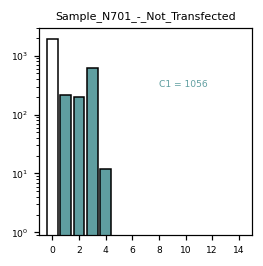

In [300]:
_,ax = plt.subplots(figsize=(2.5,2.5))
plt.title(sample)
plt.yscale('log')
plt.ylim(0,3000)
plt.xlim(-1,15)
ax.set_xticks(np.arange(0,15,2))
ax.bar(n_neighbors[0][0], n_neighbors[1][0], edgecolor = "black", color = "w");
ax.bar(n_neighbors[0][1:], n_neighbors[1][1:], color = "cadetblue", edgecolor = "black");
ax.text(8,300, f"C1 = {n_neighbors[1][1:].sum()}", color = "cadetblue");
plt.savefig(f"./figs/{prefix}_dist-nn.pdf");

/tmp/ipykernel_55590/1447142340.py:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,3000)


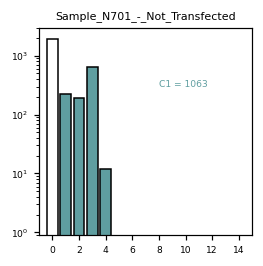

In [29]:
_,ax = plt.subplots(figsize=(2.5,2.5))
plt.title(sample)
plt.yscale('log')
plt.ylim(0,3000)
plt.xlim(-1,15)
ax.set_xticks(np.arange(0,15,2))
ax.bar(n_neighbors[0][0], n_neighbors[1][0], edgecolor = "black", color = "w");
ax.bar(n_neighbors[0][1:], n_neighbors[1][1:], color = "cadetblue", edgecolor = "black");
ax.text(8,300, f"C1 = {n_neighbors[1][1:].sum()}", color = "cadetblue");
plt.savefig(f"./figs/{prefix}_dist-nn.pdf");

In [90]:
gm = GaussianMixture(2, covariance_type="full")

X = np.array([sc.obs["DedupRate"].loc[errors]]).T

clusters = gm.fit_predict(X).astype(object)

means = pd.DataFrame({"cluster" : clusters, "dedup" : sc.obs["DedupRate"].loc[errors]}, dtype=float).groupby("cluster").mean()
sorted_cl_labels = means.sort_values(by="dedup").index.astype(int)


for cl, new_cl in zip(sorted_cl_labels, np.sort(sorted_cl_labels)) :
    clusters[clusters == cl] = str(new_cl)
    
    
sc.obs["clusters"] = np.repeat(None, sc.X.shape[0])
for barcode, cl in zip(errors, clusters) :
    sc.obs["clusters"].loc[barcode] = str(cl)

/u/davidm/VirtualEns/python_3.9.5/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [91]:
gm.weights_

array([0.90596018, 0.09403982])

In [100]:
cl1 = sc.obs_names[sc.obs["clusters"] == "0"]
cl2 = sc.obs_names[sc.obs["clusters"] == "1"]

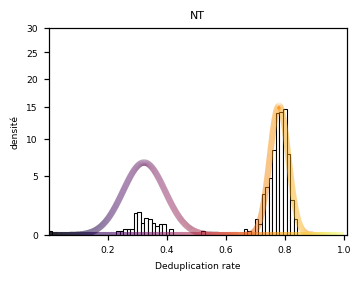

In [93]:
normalize = colors.TwoSlopeNorm(vmin=0., vcenter=.5, vmax=1)

plt.subplots(figsize=(3.5,2.5))

plt.hist(sc.obs["DedupRate"].loc[errors], bins = 70, color = "white", edgecolor = 'black', linewidth = 0.7, density=True);
plt.xlabel("Deduplication rate");
plt.ylabel("densité");


x_axis = np.arange(0, 1, 0.0001)
colorline(x_axis, norm.pdf(x_axis, gm.means_[0][0], np.sqrt(gm.covariances_[0][0])), cmap='inferno', norm=normalize, alpha = 0.6, linewidth=4)
colorline(x_axis, norm.pdf(x_axis, gm.means_[1][0], np.sqrt(gm.covariances_[1][0])), cmap='inferno', norm=normalize, alpha=0.6, linewidth=4)

plt.title("NT")
plt.yscale("squareroot")
plt.ylim(0,30)
plt.xlim(0,1.01)
plt.xticks([0.2,0.4,0.6,0.8,1.0])
plt.savefig(f"./figs/{prefix}_distrib_dedup.pdf")

In [33]:
i_corr_max = np.argsort(np.corrcoef(sc.X.toarray()), axis = 0)[-2]
barcodes_corr_max = pd.DataFrame(sc.obs["CB"].values[i_corr_max], index = sc.obs["CB"].values)

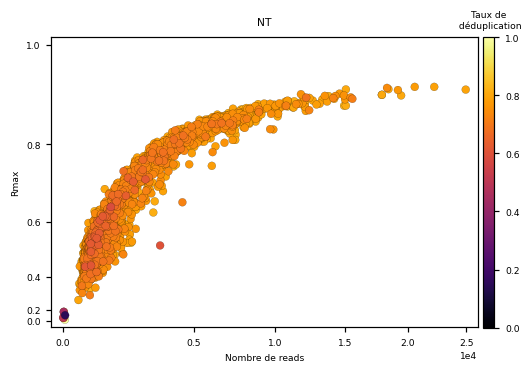

In [434]:
fig, ax = plt.subplots(figsize=(5,3.5))


# sc.obs["phred"] = total_scores.mean(1)
# color = "phred"
color = "DedupRate"
# lib_type = "raw_cb_freq"
lib_type = "total_UMIs"

# cmap = "cividis"
cmap = "inferno"
norm = colors.TwoSlopeNorm(vmin=0., vcenter=.5, vmax=1)
s = 27

            
ax.set_xlim(xmin = -150, xmax=26000)
ax.set_ylim(ymin=-0.15, ymax=1.015)
ax.set_yscale("square")
ax.set_xscale("squareroot")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))



rnaseq.plotting.scatter(sc.obs[lib_type].values, sc.obs["max_corr"].values, color = sc.obs[color].values, marker = 'o', \
            linewidth = 0.1, edgecolor = 'black', norm = norm, fig=fig, s = 27, \
            cmap = cmap, order_color = "descending",  \
            color_title = "Taux de\n déduplication", xlabel = "Nombre de reads", ylabel = "Rmax", title = "NT")    



plt.savefig(f"./figs/{prefix}_{lib_type}-max-corr_gm-clusters.pdf")

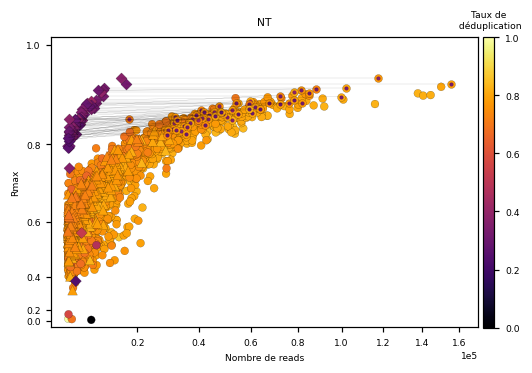

In [37]:
fig, ax = plt.subplots(figsize=(5,3.5))


# sc.obs["phred"] = total_scores.mean(1)
# color = "phred"
color = "DedupRate"
lib_type = "raw_cb_freq"
# lib_type = "total_UMIs"

# cmap = "cividis"
cmap = "inferno"
norm = colors.TwoSlopeNorm(vmin=0., vcenter=.5, vmax=1)
s = 27

edgecolors = []
linewidths = []
markers = []
sizes = []
cl0 = sc.obs_names[sc.obs["clusters"] == "0"]
cl1 = sc.obs_names[sc.obs["clusters"] == "1"]

            
for barcode in sc.obs_names :

    if barcode not in errors :
        markers.append('o')
        sizes.append(s)
    elif barcode in cl1 :
            markers.append('^')
            sizes.append(s*1.5)
    elif barcode in cl0 :
            markers.append('D')
            sizes.append(s)
            
sc.obs["marker"] = np.array(markers)
sc.obs["markersize"] = np.array(sizes)


i = 0
scatt_others = list(sc.obs_names)
for barcode in cl0 :
    neighbors = neighbors_mtx.loc[barcode]
    neighbors = neighbors.index.values[neighbors == 1]
    Rmax = barcodes_corr_max.loc[barcode][0]
    if Rmax in neighbors and sc.obs["max_corr"].loc[barcode] > 0.8 : # and sc.obs[lib_type].loc[Rmax] < 35000: 
        x = (sc.obs[lib_type].loc[barcode], sc.obs[lib_type].loc[Rmax])
        y = (sc.obs["max_corr"].loc[barcode], sc.obs["max_corr"].loc[Rmax])
        ax.plot(x,y, linewidth = 0.1, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 7, alpha = 0.5)
        ax.scatter(sc.obs[lib_type].loc[Rmax], sc.obs["max_corr"].loc[Rmax], marker = sc.obs.loc[Rmax]["marker"], \
                   s = sc.obs.loc[Rmax]["markersize"], c = sc.obs[color].loc[Rmax], edgecolors = 'black', linewidths = 0.1, \
                   cmap = cmap, norm = norm, zorder = 5)
        ax.scatter(sc.obs[lib_type].loc[Rmax], sc.obs["max_corr"].loc[Rmax], marker = '.', c = sc.obs[color].loc[barcode], \
                   edgecolors = 'black', linewidths = 0.05, cmap = cmap, norm = norm, s = 25, zorder = 5)
        ax.scatter(sc.obs[lib_type].loc[barcode], sc.obs["max_corr"].loc[barcode], marker = sc.obs.loc[barcode]["marker"], \
                   s = sc.obs.loc[barcode]["markersize"], c = sc.obs[color].loc[barcode], edgecolors = 'black', \
                   linewidths = 0.1, cmap = cmap, norm = norm, zorder = 5)
        i += 1
        if Rmax in scatt_others : scatt_others.remove(Rmax)
        if barcode in scatt_others : scatt_others.remove(barcode)

            
ax.set_xlim(xmin = 1000, xmax=170000)
ax.set_ylim(ymin=-0.15, ymax=1.015)
ax.set_yscale("square")
ax.set_xscale("squareroot")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))



rnaseq.plotting.scatter(sc.obs.loc[scatt_others][lib_type].values, sc.obs.loc[scatt_others]["max_corr"].values, sc.obs.loc[scatt_others][color].values, marker = sc.obs.loc[scatt_others]["marker"].values, \
            linewidth = 0.1, edgecolor = 'black', norm = norm, fig=fig, s = sc.obs.loc[scatt_others]["markersize"].values, \
            cmap = cmap, order_color = "descending", order_marker = {'D':3, 'o':1, '^':2, 'v':4}, \
            color_title = "Taux de\n déduplication", xlabel = "Nombre de reads", ylabel = "Rmax", title = "NT")    



plt.savefig(f"./figs/{prefix}_{lib_type}-max-corr_gm-clusters.pdf")

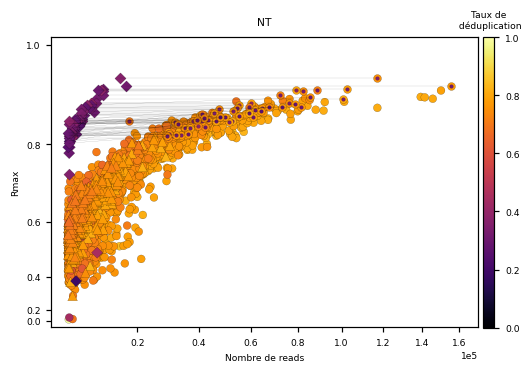

In [393]:
fig, ax = plt.subplots(figsize=(5,3.5))


# sc.obs["phred"] = total_scores.mean(1)
# color = "phred"
color = "DedupRate"
lib_type = "raw_cb_freq"
# lib_type = "total_UMIs"

# cmap = "cividis"
cmap = "inferno"
norm = colors.TwoSlopeNorm(vmin=0., vcenter=.5, vmax=1)
s = 27

edgecolors = []
linewidths = []
markers = []
sizes = []
cl0 = sc.obs_names[sc.obs["clusters"] == "0"]
cl1 = sc.obs_names[sc.obs["clusters"] == "1"]

            
for barcode in sc.obs_names :

    if barcode not in errors :
        markers.append('o')
        sizes.append(s)
    elif barcode in cl1 :
            markers.append('^')
            sizes.append(s*1.5)
    elif barcode in cl0 :
            markers.append('D')
            sizes.append(s)
            
sc.obs["marker"] = np.array(markers)
sc.obs["markersize"] = np.array(sizes)


i = 0
scatt_others = list(sc.obs_names)
for barcode in cl0 :
    neighbors = neighbors_mtx.loc[barcode]
    neighbors = neighbors.index.values[neighbors == 1]
    Rmax = barcodes_corr_max.loc[barcode][0]
    if Rmax in neighbors and sc.obs["max_corr"].loc[barcode] > 0.8 : # and sc.obs[lib_type].loc[Rmax] < 35000: 
        x = (sc.obs[lib_type].loc[barcode], sc.obs[lib_type].loc[Rmax])
        y = (sc.obs["max_corr"].loc[barcode], sc.obs["max_corr"].loc[Rmax])
        ax.plot(x,y, linewidth = 0.1, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 7, alpha = 0.5)
        ax.scatter(sc.obs[lib_type].loc[Rmax], sc.obs["max_corr"].loc[Rmax], marker = sc.obs.loc[Rmax]["marker"], \
                   s = sc.obs.loc[Rmax]["markersize"], c = sc.obs[color].loc[Rmax], edgecolors = 'black', linewidths = 0.1, \
                   cmap = cmap, norm = norm, zorder = 5)
        ax.scatter(sc.obs[lib_type].loc[Rmax], sc.obs["max_corr"].loc[Rmax], marker = '.', c = sc.obs[color].loc[barcode], \
                   edgecolors = 'black', linewidths = 0.05, cmap = cmap, norm = norm, s = 25, zorder = 5)
        ax.scatter(sc.obs[lib_type].loc[barcode], sc.obs["max_corr"].loc[barcode], marker = sc.obs.loc[barcode]["marker"], \
                   s = sc.obs.loc[barcode]["markersize"], c = sc.obs[color].loc[barcode], edgecolors = 'black', \
                   linewidths = 0.1, cmap = cmap, norm = norm, zorder = 5)
        i += 1
        if Rmax in scatt_others : scatt_others.remove(Rmax)
        if barcode in scatt_others : scatt_others.remove(barcode)

            
ax.set_xlim(xmin = 1000, xmax=170000)
ax.set_ylim(ymin=-0.15, ymax=1.015)
ax.set_yscale("square")
ax.set_xscale("squareroot")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))



rnaseq.plotting.scatter(sc.obs.loc[scatt_others][lib_type].values, sc.obs.loc[scatt_others]["max_corr"].values, sc.obs.loc[scatt_others][color].values, marker = sc.obs.loc[scatt_others]["marker"].values, \
            linewidth = 0.1, edgecolor = 'black', norm = norm, fig=fig, s = sc.obs.loc[scatt_others]["markersize"].values, \
            cmap = cmap, order_color = "descending", order_marker = {'D':3, 'o':1, '^':2, 'v':4}, \
            color_title = "Taux de\n déduplication", xlabel = "Nombre de reads", ylabel = "Rmax", title = "NT")    



plt.savefig(f"./figs/{prefix}_{lib_type}-max-corr_gm-clusters.pdf")

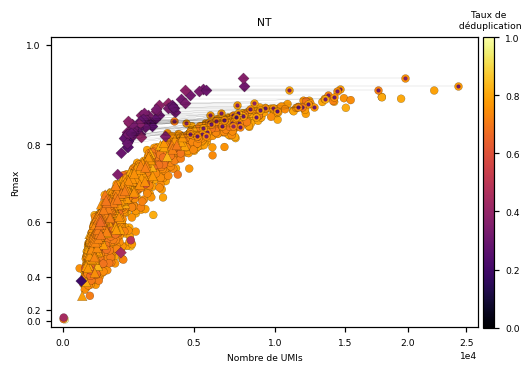

In [392]:
fig, ax = plt.subplots(figsize=(5,3.5))


# sc.obs["phred"] = total_scores.mean(1)
# color = "phred"
color = "DedupRate"
lib_type = "total_UMIs"

# cmap = "cividis"
cmap = "inferno"
norm = colors.TwoSlopeNorm(vmin=0., vcenter=.5, vmax=1)
s = 27

edgecolors = []
linewidths = []
markers = []
sizes = []
cl0 = sc.obs_names[sc.obs["clusters"] == "0"]
cl1 = sc.obs_names[sc.obs["clusters"] == "1"]

            
for barcode in sc.obs_names :

    if barcode not in errors :
        markers.append('o')
        sizes.append(s)
    elif barcode in cl1 :
            markers.append('^')
            sizes.append(s*1.5)
    elif barcode in cl0 :
            markers.append('D')
            sizes.append(s)
            
sc.obs["marker"] = np.array(markers)
sc.obs["markersize"] = np.array(sizes)


i = 0
scatt_others = list(sc.obs_names)
for barcode in cl0 :
    neighbors = neighbors_mtx.loc[barcode]
    neighbors = neighbors.index.values[neighbors == 1]
    Rmax = barcodes_corr_max.loc[barcode][0]
    if Rmax in neighbors and sc.obs["max_corr"].loc[barcode] > 0.8 : # and sc.obs[lib_type].loc[Rmax] < 35000: 
        x = (sc.obs[lib_type].loc[barcode], sc.obs[lib_type].loc[Rmax])
        y = (sc.obs["max_corr"].loc[barcode], sc.obs["max_corr"].loc[Rmax])
        ax.plot(x,y, linewidth = 0.1, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 7, alpha = 0.5)
        ax.scatter(sc.obs[lib_type].loc[Rmax], sc.obs["max_corr"].loc[Rmax], marker = sc.obs.loc[Rmax]["marker"], \
                   s = sc.obs.loc[Rmax]["markersize"], c = sc.obs[color].loc[Rmax], edgecolors = 'black', linewidths = 0.1, \
                   cmap = cmap, norm = norm, zorder = 5)
        ax.scatter(sc.obs[lib_type].loc[Rmax], sc.obs["max_corr"].loc[Rmax], marker = '.', c = sc.obs[color].loc[barcode], \
                   edgecolors = 'black', linewidths = 0.05, cmap = cmap, norm = norm, s = 25, zorder = 5)
        ax.scatter(sc.obs[lib_type].loc[barcode], sc.obs["max_corr"].loc[barcode], marker = sc.obs.loc[barcode]["marker"], \
                   s = sc.obs.loc[barcode]["markersize"], c = sc.obs[color].loc[barcode], edgecolors = 'black', \
                   linewidths = 0.1, cmap = cmap, norm = norm, zorder = 5)
        i += 1
        if Rmax in scatt_others : scatt_others.remove(Rmax)
        if barcode in scatt_others : scatt_others.remove(barcode)

            
ax.set_xlim(xmin = -150, xmax=26000)
ax.set_ylim(ymin=-0.15, ymax=1.015)
ax.set_yscale("square")
ax.set_xscale("squareroot")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))



rnaseq.plotting.scatter(sc.obs.loc[scatt_others][lib_type].values, sc.obs.loc[scatt_others]["max_corr"].values, sc.obs.loc[scatt_others][color].values, marker = sc.obs.loc[scatt_others]["marker"].values, \
            linewidth = 0.1, edgecolor = 'black', norm = norm, fig=fig, s = sc.obs.loc[scatt_others]["markersize"].values, \
            cmap = cmap, order_color = "descending", order_marker = {'D':3, 'o':1, '^':2, 'v':4}, \
            color_title = "Taux de\n déduplication", xlabel = "Nombre de UMIs", ylabel = "Rmax", title = "NT")    



plt.savefig(f"./figs/{prefix}_{lib_type}-max-corr_gm-clusters.pdf")

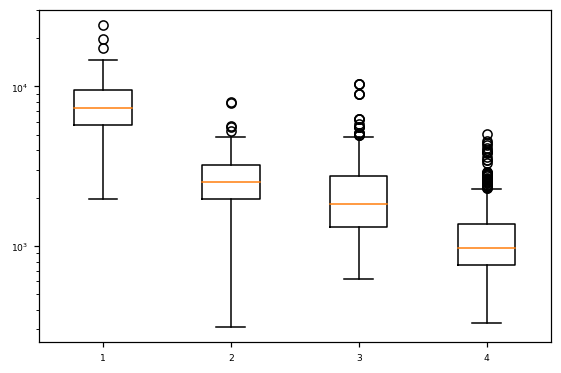

In [415]:
a = sc.obs.loc[get_intended_barcodes(correction_dict, cl0)[0]]["total_UMIs"]
b = sc.obs.loc[get_intended_barcodes(correction_dict, cl0)[1]]["total_UMIs"]
c = sc.obs.loc[get_intended_barcodes(correction_dict, cl1)[0]]["total_UMIs"]
d = sc.obs.loc[get_intended_barcodes(correction_dict, cl1)[1]]["total_UMIs"]

plt.boxplot([a,b,c,d]);
plt.yscale('log')

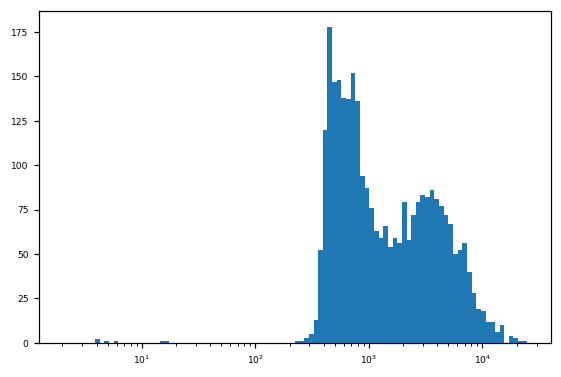

In [17]:
tot = sc.obs["total_UMIs"]
rnaseq.plotting.loghist(tot, bins=100);

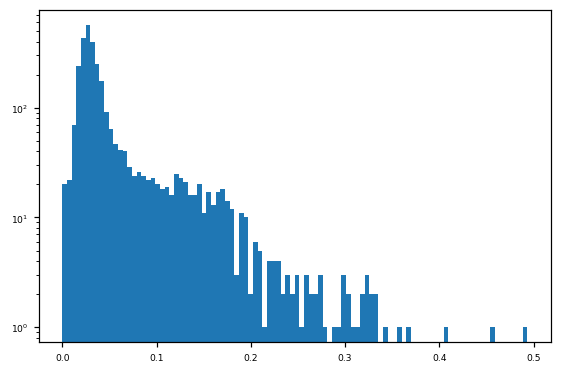

In [22]:
tot = sc.obs["mt_frac"]
plt.hist(tot, bins=100)
plt.yscale('log');

In [64]:
rnaseq.pp.filter_cells(sc, mt_max=0.06, n_counts_min=1400, inplace=True)

In [76]:
rnaseq.setup.load_layer(sc,"raw")
rnaseq.setup.annotate_samples(sc, samples_annot_name = "rp_frac", ow=True)

Annotating rp_frac...
external_gene_name already annotated. Set ow = True if you want to overwrite.


In [98]:
rnaseq.pp.log_norm(sc)
scanpy.pp.pca(sc, n_comps = 50)
scanpy.pp.neighbors(sc, n_pcs=8)
scanpy.tl.umap(sc)

Dataset already log-normalized.


In [66]:
rnaseq.setup.annotate_genes(sc, "external_gene_name")

external_gene_name already annotated. Set ow = True if you want to overwrite.


In [634]:
sc.uns["layer"]

'log_norm'

In [95]:
# sc._inplace_subset_obs(sc.obs["louvain"] != '1')

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [114]:
scanpy.tl.louvain(sc, resolution=0.4)

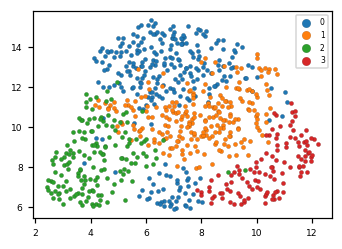

In [115]:
# g = sc.layers["raw"].toarray()[:, np.intersect1d(sc.var["external_gene_name"], ["ABCG2"], return_indices=True)[1]].sum(1)/sc.obs["total_UMIs"]
g = sc.X.toarray()[:, sc.var["external_gene_name"] == "TWIST2 "]


rnaseq.plotting.scatter(sc.obsm["X_umap"].T[0], sc.obsm["X_umap"].T[1], s = 8, linewidth=0.07, color = sc.obs["louvain"])

In [104]:
sc.var_names = sc.var["external_gene_name"]
scanpy.tl.rank_genes_groups(sc, groupby = 'louvain', method='wilcoxon', n_genes=1000, rankby_abs=True)

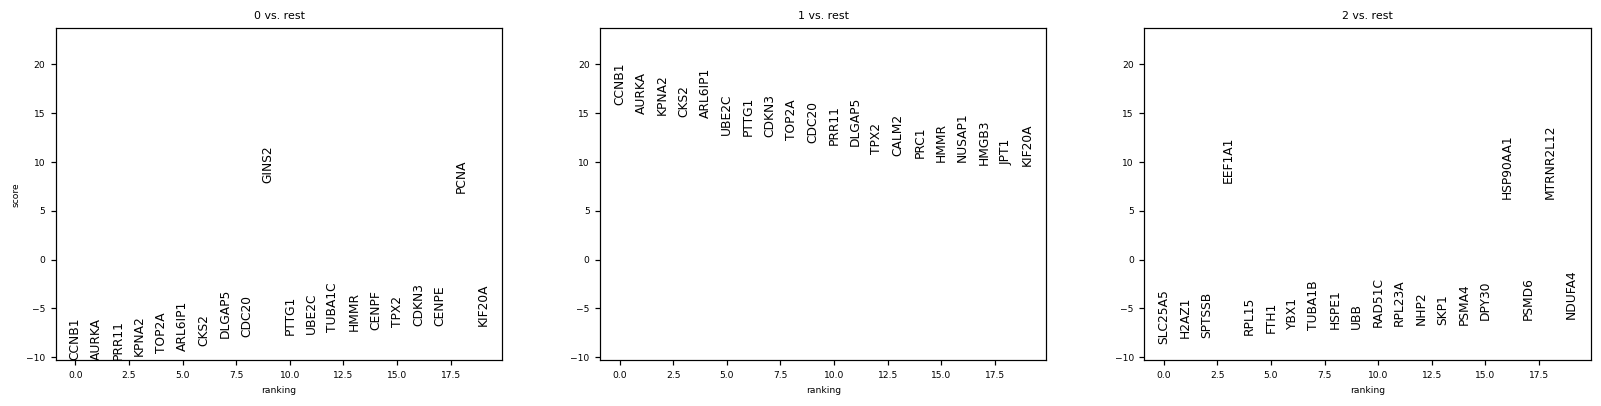

In [106]:
# gene_rank = pd.DataFrame([[g[0] for g in sc.uns["wilcoxon"]["names"]], [g[0] for g in sc.uns["wilcoxon"]["logfoldchanges"]]]).T
scanpy.pl.rank_genes_groups(sc)

/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/dea.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x = pd.DataFrame(np.array(data[gene_set_library])[:,1:], columns=["Term", "P-value", "Z-score", "Combined Score", "Genes", "Adjusted P-value", "Old P-value", "Old adjusted P-value"])
/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/dea.py:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


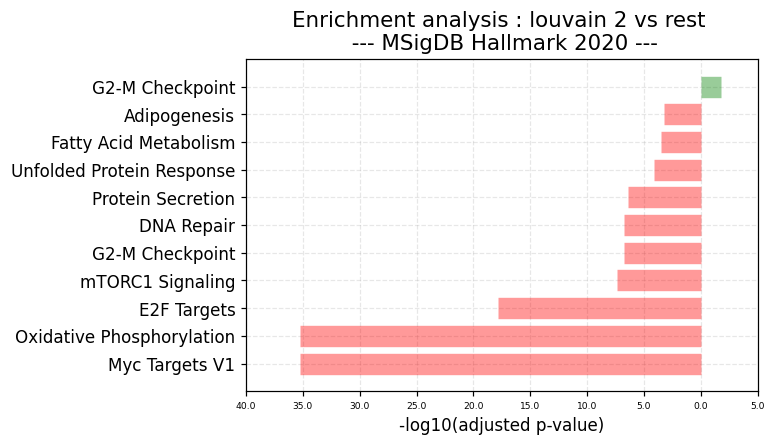

index                       Term      P-value  Z-score Combined Score  \
0       0             Myc Targets V1  2.36271e-37  12.0404        1015.43   
1       1  Oxidative Phosphorylation  2.36271e-37  12.0404        1015.43   
2       2                E2F Targets  9.43935e-20  7.21748        316.175   
3       3           mTORC1 Signaling  3.99035e-09  4.27746        82.7236   
4       4            G2-M Checkpoint  1.71609e-08  4.08929         73.119   
5       5                 DNA Repair  2.39507e-08  4.68812        82.2638   
6       6          Protein Secretion  5.61852e-08    5.843        97.5466   
7       7  Unfolded Protein Response  1.39661e-05  4.14021        46.2829   
8       8      Fatty Acid Metabolism  6.13841e-05  3.26316        31.6473   
9       9               Adipogenesis  0.000126317  2.84319        25.5225   
10      0            G2-M Checkpoint   0.00424723  24.9899        136.482   

                                                Genes  Adjusted P-value  \
0   [EIF4A1, PWP1, UBE2L3, PSMD8, FBL, SNRPD2, YWH...        -35.255522   
1   [COX4I1, ETFA, ETFB, TIMM17A, ATP6V0E1, ECH1, ...        -35.255522   
2   [SLBP, NUP107, CDCA3, SHMT1, AK2, CKS1B, PTTG1...        -17.830081   
3   [RAB1A, PSMD12, TOMM40, PSMD14, UBE2D3, PSMB5,...         -7.328951   
4   [DTYMK, CKS1B, PTTG1, SNRPD1, TRA2B, STMN1, NS...         -6.792331   
5   [RFC3, GTF2A2, RALA, TSG101, ARL6IP1, TAF9, AD...         -6.726736   
6   [TPD52, TMED10, TSG101, BNIP3, ICA1, CLTA, SCA...         -6.423378   
7   [EIF4A1, POP4, EIF4A3, LSM1, LSM4, YIF1A, CKS1...         -4.085917   
8   [H2AZ1, PDHA1, MDH1, MDH2, IDH1, ECH1, SDHC, S...         -3.494089   
9   [MDH2, MGST3, IDH1, ECH1, AK2, SDHC, MRPL15, U...         -3.226439   
10                                       [NCL, KPNB1]          1.769834   

   Old P-value Old adjusted P-value  color  
0            0                    0    red  
1            0                    0    red  
2            0                    0    red  
3            0                    0    red  
4            0                    0    red  
5            0                    0    red  
6            0                    0    red  
7            0                    0    red  
8            0                    0    red  
9            0                    0    red  
10           0                    0  green

In [112]:
rnaseq.dea.enrichr(sc, group='2', libraries="MSigDB_Hallmark_2020", lfc_cutoff=0.5)

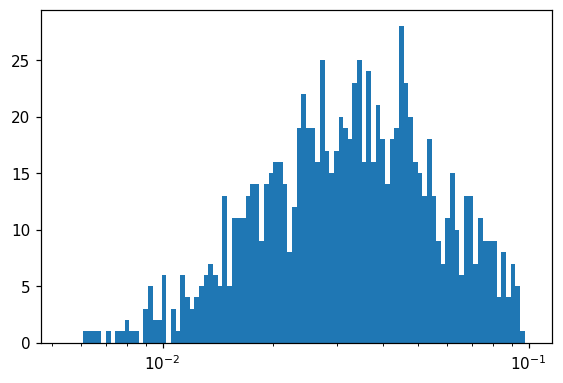

In [854]:
rp = sc.obs["rp_frac"]
rnaseq.plotting.loghist(rp, bins=100);

In [847]:
scanpy.tl.rank_genes_groups(sc, groupby="louvain", rankby_abs=True)

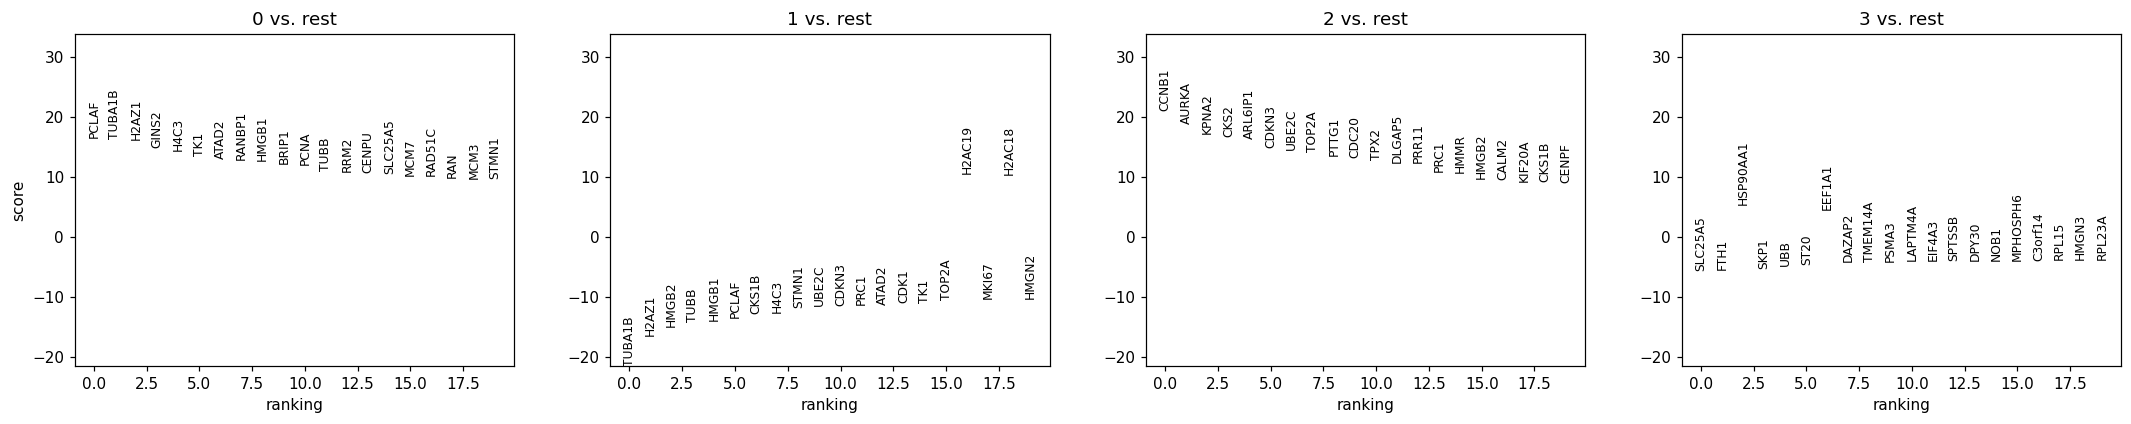

In [848]:
scanpy.pl.rank_genes_groups(sc, gene_symbols="external_gene_name")

In [806]:
annot_path = "/home/arion/davidm/Data/references/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"

bulk_salmon_decoys = rnaseq.readwrite.read_raw(project_id  = "dsp356", quant_tool = "salmon", samples = "Sample_E-1", genes_id = "ensembl_gene_id", quant_params = "raw-reads/pc-decoys-k31-1.4.0", genref = genref, layer = "norm", cdna = "full length", exp = "bulk")
rnaseq.setup.annotate_genes(bulk_salmon_decoys, genes_annot_name = "exonic_length", compute_length = {"start" : "exon_chrom_start", "stop" : "exon_chrom_end"}, save_path = annot_path + "/biomart_ens100")
rnaseq.pp.log_norm(bulk_salmon_decoys, tot=1e6)

/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
Annotating exonic_length using /home/arion/davidm/Data/references/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/biomart_ens100/ensembl_gene_id-to-exonic_length.csv...
Dataset already normalized.
Log2 + 1 tranformation...


In [812]:
rnaseq.setup.load_layer(sc, "raw")
ps_decoys = rnaseq.utils.pseudobulk(sc)
rnaseq.pp.log_norm(ps_decoys, tot=1e6)

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
Normalization by total UMIs...
This is CPM normalization.
Log2 + 1 tranformation...


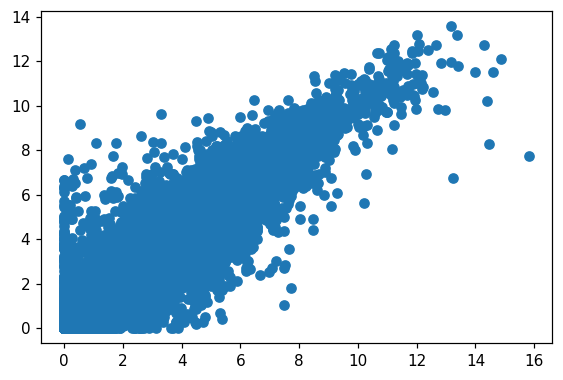

In [813]:
rnaseq.utils.match_genes([bulk_salmon_decoys, ps_decoys])
plt.scatter(bulk_salmon_decoys.X.toarray(), ps_decoys.X.toarray());

In [829]:
rnaseq.setup.annotate_genes(ps_decoys, "external_gene_name")
ps_decoys.var["external_gene_name"][(ps_decoys.X.toarray().ravel() >= 4) & (bulk_salmon_decoys.X.toarray().ravel() <=1)]

external_gene_name already annotated. Set ow = True if you want to overwrite.


ENSG00000006747               SCIN
ENSG00000125695         AC046185.1
ENSG00000125954        CHURC1-FNTB
ENSG00000161939    RNASEK-C17orf49
ENSG00000172717             FAM71D
ENSG00000173867         AC013489.1
ENSG00000198211         AC092143.1
ENSG00000235272             RAMACL
ENSG00000236444             UBE2L5
ENSG00000248167       TRIM39-RPP21
ENSG00000249773         AC092647.5
ENSG00000251357         AP000350.4
ENSG00000254692         AL136295.1
ENSG00000254732         AP001931.1
ENSG00000254870    ATP6V1G2-DDX39B
ENSG00000255730         AC011462.1
ENSG00000255872         AL138752.2
ENSG00000257390         AC023055.1
ENSG00000257524         AL157935.3
ENSG00000257921         AC025165.3
ENSG00000259522         AL136295.4
ENSG00000260272         AC093525.2
ENSG00000260836         AC245033.1
ENSG00000261147         AC091167.2
ENSG00000261832         AC138894.1
ENSG00000261915         AC026954.2
ENSG00000262526         AC120057.2
ENSG00000264058         AC073508.2
ENSG00000267426     

In [701]:
rnaseq.dea.enrichr(sc, group="2", libraries=["MSigDB_Hallmark_2020"], top = 2)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


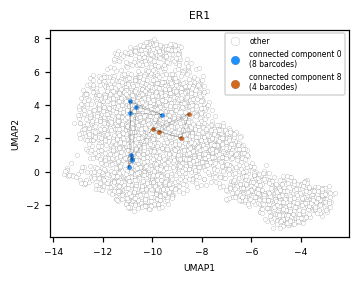

In [418]:
fig,_ = plt.subplots(figsize=(3.5,2.5))

comps = [0,8]
a,b = comps

texts = []
sc.obs["select"] = np.repeat("other", len(sc.obs_names))

for barcode in sc.obs_names :
    for i in comps :
        if barcode in connected_components[i] :
            sc.obs["select"].loc[barcode] = f"connected component {i}\n({len(connected_components[i])} barcodes)"


explored = []
for i in comps :
    for barcode1 in connected_components[i] :
        for barcode2 in connected_components[i] :
            if hammingDist(barcode1, barcode2) == 1 and {barcode1,barcode2} not in explored :
                x = (sc[barcode1].obsm["X_umap"].T[0], sc[barcode2].obsm["X_umap"].T[0])
                y = (sc[barcode1].obsm["X_umap"].T[1], sc[barcode2].obsm["X_umap"].T[1])
                plt.plot(x,y, linewidth = 0.1, color = "black")
                explored.append({barcode1, barcode2})
    #     texts.append(plt.text(sc[barcode1].obsm["X_umap"].T[0],\
    #                               sc[barcode1].obsm["X_umap"].T[1], barcode1, fontsize = 5.5))


rnaseq.plotting.scatter(sc.obsm["X_umap"].T[0], sc.obsm["X_umap"].T[1], s = 8, linewidth=0.07, color = sc.obs["select"].values,\
                        xlabel = "UMAP1", ylabel="UMAP2",\
                        title = "ER1",\
                        palette = {f"connected component 0\n({len(connected_components[0])} barcodes)" : "dodgerblue", \
                                   f"connected component {b}\n({len(connected_components[b])} barcodes)" : "chocolate", \
                                   "other":"white"}, \
                        fig = fig, order_color = ["other", f"connected component 0\n({len(connected_components[0])} barcodes)", \
                                                 f"connected component {b}\n({len(connected_components[b])} barcodes)"])
adjust_text(texts)
plt.savefig(f"./figs/{prefix}_umap.pdf")
plt.show()

### Errors patterns

In [366]:
n_neighbors_cl0 = neighbors_mtx.loc[cl0].sum(0)
stats.pearsonr(n_neighbors_cl0, sc.obs["raw_cb_freq"].values)

(0.36430068456414505, 8.047972205465729e-95)

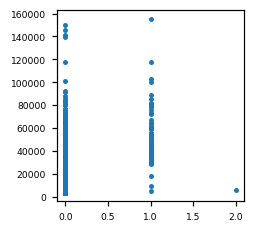

In [372]:
_, ax = plt.subplots(figsize=(2.2, 2.3))
ax.scatter(n_neighbors_cl0, sc.obs["raw_cb_freq"].values, s = 5)

In [368]:
n_neighbors_cl1 = neighbors_mtx.loc[cl1].sum(0)
stats.pearsonr(n_neighbors_cl1, sc.obs["raw_cb_freq"].values)

(-0.16212890522149095, 4.048153868276963e-19)

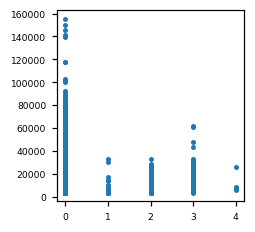

In [373]:
_, ax = plt.subplots(figsize=(2.2, 2.3))
ax.scatter(n_neighbors_cl1, sc.obs["raw_cb_freq"].values, s = 5)

In [370]:
n_neighbors = neighbors_mtx.sum(0)
stats.pearsonr(n_neighbors, sc.obs["raw_cb_freq"].values)

(-0.1663148472652263, 4.7489586036072945e-20)

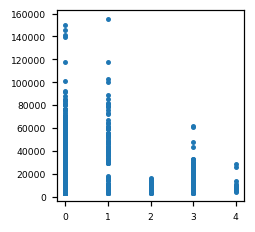

In [375]:
_, ax = plt.subplots(figsize=(2.2, 2.3))
ax.scatter(n_neighbors, sc.obs["raw_cb_freq"].values, s = 5)

In [376]:
np.save("n_neighbors.npy", n_neighbors)
np.save("raw_cb_freq.npy", sc.obs["raw_cb_freq"].values)

In [97]:
barcodes = sc.obs_names

hamming_neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
for i in range(len(hamming_neighbors_mtx)) :
    barcode1 = sc.obs["CB"].values[i]
    hamming_neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in barcodes]
hamming_neighbors_mtx = pd.DataFrame(hamming_neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)

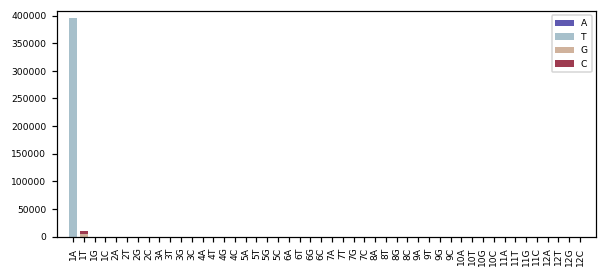

In [101]:
plot_errors(cl1, libs, hamming_neighbors_mtx)
plt.savefig(f"./figs/{prefix}_cl1_errors.pdf")

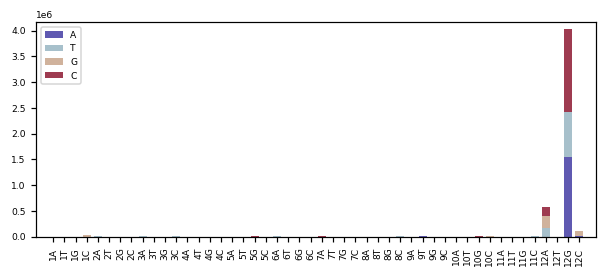

In [102]:
plot_errors(cl2, libs, hamming_neighbors_mtx)
plt.savefig(f"./figs/{prefix}_cl2_errors.pdf")

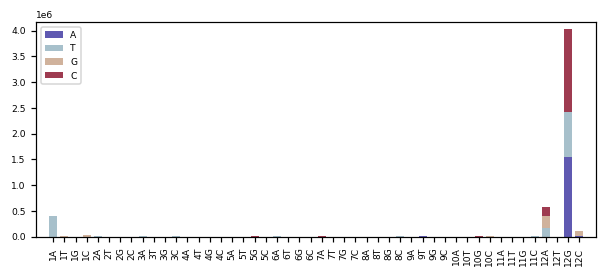

In [103]:
plot_errors(errors, libs, hamming_neighbors_mtx)
plt.savefig(f"./figs/{prefix}_all_errors.pdf")

In [397]:
project_path = "/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779"
x = pd.read_csv(f"{project_path}/raw-fastqs/{sample}/new_umis.csv")

In [410]:
tfrac_cl1 = []

for cb in cl0 :
    umis = np.concatenate([ast.literal_eval(x[cb].values[chunk]) for chunk in range(x.shape[0])])
    numis_cl1 = len(umis)
    tumis_cl1 = 0
    for u in umis :
        if u[-1] == 'T':
            tumis_cl1 += 1
    tfrac_cl1.append(tumis_cl1/numis_cl1)

In [412]:
tfrac_cl1

[0.1979277051689627,
 0.1577153148517399,
 0.08284291534631055,
 0.15928959234379314,
 0.11854103343465046,
 0.18273284783441932,
 0.1455578512396694,
 0.006278599553048846,
 0.19893697798025817,
 0.1240043057050592,
 0.1232813932172319,
 0.08360009849790692,
 0.14211438474870017,
 0.16993627389728852,
 0.13690322580645162,
 0.1696122756541992,
 0.1732272069464544,
 0.2152187120291616,
 0.1459661122337945,
 0.1682258064516129,
 0.11926456231695412,
 0.1508841513799372,
 0.1306284017812964,
 0.09077001529831719,
 0.1168940542361462,
 0.11103388357949609,
 0.17485574401119078,
 0.17228070175438598,
 0.13036593947923997,
 0.1426543647977289,
 0.12944162436548223,
 0.1736071496482221,
 0.01180061037639878,
 0.08791658147618074,
 0.25301957517700957,
 0.09737281067556297,
 0.12354409317803661,
 0.17181913774973712,
 0.0911408540471638,
 0.11831166062673204,
 0.23571883627097048,
 0.16620557565439456,
 0.08831341301460824,
 0.15463447961739923,
 0.146245969599263,
 0.17669261618306203,
 0.19

In [413]:
tfrac_cl2 = []

for cb in cl1 :
    umis = np.concatenate([ast.literal_eval(x[cb].values[chunk]) for chunk in range(x.shape[0])])
    numis_cl2 = len(umis)
    tumis_cl2 = 0
    for u in umis :
        if u[-1] == 'T':
            tumis_cl2 += 1
    tfrac_cl2.append(tumis_cl2/numis_cl2)

In [414]:
tfrac_cl1

[0.1979277051689627,
 0.1577153148517399,
 0.08284291534631055,
 0.15928959234379314,
 0.11854103343465046,
 0.18273284783441932,
 0.1455578512396694,
 0.006278599553048846,
 0.19893697798025817,
 0.1240043057050592,
 0.1232813932172319,
 0.08360009849790692,
 0.14211438474870017,
 0.16993627389728852,
 0.13690322580645162,
 0.1696122756541992,
 0.1732272069464544,
 0.2152187120291616,
 0.1459661122337945,
 0.1682258064516129,
 0.11926456231695412,
 0.1508841513799372,
 0.1306284017812964,
 0.09077001529831719,
 0.1168940542361462,
 0.11103388357949609,
 0.17485574401119078,
 0.17228070175438598,
 0.13036593947923997,
 0.1426543647977289,
 0.12944162436548223,
 0.1736071496482221,
 0.01180061037639878,
 0.08791658147618074,
 0.25301957517700957,
 0.09737281067556297,
 0.12354409317803661,
 0.17181913774973712,
 0.0911408540471638,
 0.11831166062673204,
 0.23571883627097048,
 0.16620557565439456,
 0.08831341301460824,
 0.15463447961739923,
 0.146245969599263,
 0.17669261618306203,
 0.19

In [318]:
low_dedup_shared_umis_e = []
random_low_dedup_shared_umis_e = []

normal_dedup_shared_umis_e = []
random_normal_dedup_shared_umis_e = []


data = sc.obs["total_UMIs"].loc[np.setdiff1d(whitelist, correction_dict.keys())].to_dict()

for o,e in zip(get_intended_barcodes(correction_dict, cl0)[0], get_intended_barcodes(correction_dict, cl0)[1]) :
    
    cb1 = min(data.items(), key=lambda x: abs(sc.obs["total_UMIs"].loc[o] - x[1]))[0]
    cb2 = min(data.items(), key=lambda x: abs(sc.obs["total_UMIs"].loc[e] - x[1]))[0]
    data.pop(cb2, None)
    umis_cb1 = np.unique(np.concatenate([ast.literal_eval(x[cb1].values[chunk]) for chunk in range(x.shape[0])]))
    umis_cb2 = np.unique(np.concatenate([ast.literal_eval(x[cb2].values[chunk]) for chunk in range(x.shape[0])]))
    shared_umis = len(np.intersect1d(umis_cb1, umis_cb2))
    random_low_dedup_shared_umis_e.append(shared_umis/len(umis_cb2))
    
    umis_e = np.unique(np.concatenate([ast.literal_eval(x[e].values[chunk]) for chunk in range(x.shape[0])]))
    umis_o = np.unique(np.concatenate([ast.literal_eval(x[o].values[chunk]) for chunk in range(x.shape[0])]))
    shared_umis = len(np.intersect1d(umis_e, umis_o))
    low_dedup_shared_umis_e.append(shared_umis/len(umis_e))



data = sc.obs["total_UMIs"].loc[np.setdiff1d(whitelist, correction_dict.keys())].to_dict()

for o,e in zip(get_intended_barcodes(correction_dict, cl1)[0], get_intended_barcodes(correction_dict, cl1)[1]) :
    
    cb1 = min(data.items(), key=lambda x: abs(sc.obs["total_UMIs"].loc[o] - x[1]))[0]
    cb2 = min(data.items(), key=lambda x: abs(sc.obs["total_UMIs"].loc[e] - x[1]))[0]
    data.pop(cb2, None)
    umis_cb1 = np.unique(np.concatenate([ast.literal_eval(x[cb1].values[chunk]) for chunk in range(x.shape[0])]))
    umis_cb2 = np.unique(np.concatenate([ast.literal_eval(x[cb2].values[chunk]) for chunk in range(x.shape[0])]))
    shared_umis = len(np.intersect1d(umis_cb1, umis_cb2))
    random_normal_dedup_shared_umis_e.append(shared_umis/len(umis_cb2))
    
    umis_e = np.unique(np.concatenate([ast.literal_eval(x[e].values[chunk]) for chunk in range(x.shape[0])]))
    umis_o = np.unique(np.concatenate([ast.literal_eval(x[o].values[chunk]) for chunk in range(x.shape[0])]))
    shared_umis = len(np.intersect1d(umis_e, umis_o))
    normal_dedup_shared_umis_e.append(shared_umis/len(umis_e))




# random_shared_umis = []
# for i in range(len(cl1)):
#     cb1,cb2 = np.random.choice(whitelist, 2, replace = False)
#     umis_cb1 = np.unique(np.concatenate([ast.literal_eval(x[cb1].values[chunk]) for chunk in range(x.shape[0])]))
#     umis_cb2 = np.unique(np.concatenate([ast.literal_eval(x[cb2].values[chunk]) for chunk in range(x.shape[0])]))
#     n_umis = min([len(umis_cb2),len(umis_cb2)])
#     shared_umis = len(np.intersect1d(umis_cb1, umis_cb2))
#     random_shared_umis.append(shared_umis/n_umis)

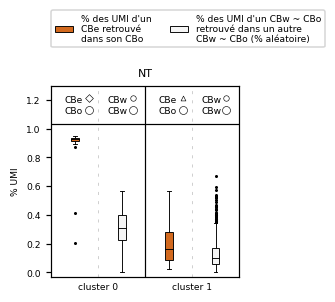

In [320]:
_, ax = plt.subplots(figsize=(2.2, 2.3))



bp = plt.boxplot(low_dedup_shared_umis_e, positions = [-0.25], widths = 0.25, patch_artist = True,\
                 boxprops={'facecolor': 'chocolate', 'color' : 'black', 'linewidth': 0.6},\
                 whiskerprops = {'linewidth': 0.6, 'color':'black'},\
                 capprops = {'linewidth': 0.6, 'color':'black'},\
                 medianprops = {'color' : 'black', 'linewidth' : 0.6},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'black', 'markeredgecolor':'black'})

bp = plt.boxplot(random_low_dedup_shared_umis_e, positions = [1.25], widths = 0.25, patch_artist = True,\
                 boxprops={'facecolor': 'whitesmoke', 'color' : 'black', 'linewidth': 0.6},\
                 whiskerprops = {'linewidth': 0.6, 'color':'black'},\
                 capprops = {'linewidth': 0.6, 'color':'black'},\
                 medianprops = {'color' : 'black', 'linewidth' : 0.6},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'black', 'markeredgecolor':'black'})



bp1 = plt.boxplot(normal_dedup_shared_umis_e, positions = [2.75], widths = 0.25, patch_artist = True,\
                 boxprops={'facecolor': 'chocolate', 'color' : 'black', 'linewidth': 0.6},\
                 whiskerprops = {'linewidth': 0.6, 'color':'black'},\
                 capprops = {'linewidth': 0.6, 'color':'black'},\
                 medianprops = {'color' : 'black', 'linewidth' : 0.6},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'black', 'markeredgecolor':'black'})
bp2 = plt.boxplot(random_shared_umis, positions = [4.25], widths = 0.25, patch_artist = True,\
                 boxprops={'facecolor': 'whitesmoke', 'color' : 'black', 'linewidth': 0.6},\
                 whiskerprops = {'linewidth': 0.6, 'color':'black'},\
                 capprops = {'linewidth': 0.6, 'color':'black'},\
                 medianprops = {'color' : 'black', 'linewidth' : 0.6},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'black', 'markeredgecolor':'black'})



ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ["% des UMI d'un\nCBe retrouvé\ndans son CBo", \
                    "% des UMI d'un CBw ~ CBo\nretrouvé dans un autre\nCBw ~ CBo (% aléatoire)"],loc=(0,1.2), ncol=2)



plt.axhline(y=1.03, linewidth = 0.8, color="black")
plt.axvline(x=0.5, linewidth = 0.4, color="black", ls=(0, (5, 10)), alpha = 0.3)
plt.axvline(x=2, linewidth = 0.8, color="black")
plt.axvline(x=3.5, linewidth = 0.4, color="black", ls=(0, (5, 10)), alpha = 0.3)



plt.scatter([1.6,4.6],np.repeat(1.213,2), marker='o', s = 13, color='white', edgecolors='black', linewidths=0.4)
plt.scatter([0.2,1.6,3.2,4.6],np.repeat(1.13,4), marker='o', s = 27, color='white', edgecolors='black', linewidths=0.4)
plt.scatter(0.2, 1.213, marker='D', s = 13, color='white', edgecolors='black', linewidths=0.4)
plt.scatter(3.2, 1.213, marker='^', s = 10, color='white', edgecolors='black', linewidths=0.4)


plt.text(-0.58, 1.185, "CBe")
plt.text(-0.58, 1.11, "CBo")
plt.text(x = 2.43, y = 1.185, s = "CBe")
plt.text(x = 2.43, y = 1.11, s = "CBo")

plt.text(0.8, 1.185, "CBw")
plt.text(0.8, 1.11, "CBw")
plt.text(3.8, 1.185, "CBw")
plt.text(3.8, 1.11, "CBw")


plt.xticks([0.5,3.5,6.5], labels=["cluster 0", "cluster 1", "cluster 2"])
ax.tick_params(axis='x', length = 0)

plt.xlim(-1,5)
plt.ylim(-0.03,1.3)

plt.ylabel("% UMI")
plt.title("NT")

plt.savefig(f"./figs/{prefix}_shared_umis.pdf")

In [321]:
project_path = "/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779"
x = pd.read_csv(f"{project_path}/raw-fastqs/{sample}/new_phreds.csv")

In [322]:
total_scores = []

for barcode in sc.obs["CB"] :
#     phreds = np.concatenate([ast.literal_eval(chunk) for chunk in x[barcode].values])
    phreds = ast.literal_eval(x[barcode].values[0])[:10000]
    scores = []
    for phred in phreds :
        scores.append([ord(str(s))-33 for s in phred[:12]])
    total_scores.append(np.mean(scores, axis = 0))

total_scores = np.array(total_scores)

In [323]:
corrected_low_dedup_phreds = np.array(total_scores[[b in cl0 for b in sc.obs_names]])
corrected_normal_dedup_phreds = np.array(total_scores[[b in cl1 for b in sc.obs_names]])
random_phreds = np.array(total_scores[[b in whitelist for b in sc.obs_names]])

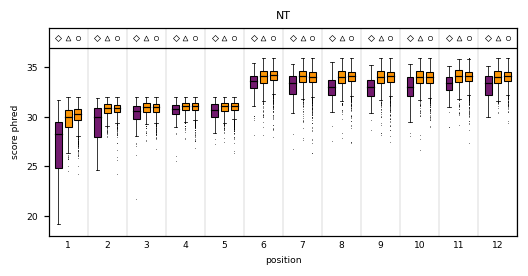

In [331]:
_, ax = plt.subplots(figsize=(5.5, 2.5))

flierprops = {'marker':'.', 'markersize':1, 'markeredgecolor':'none', 'markerfacecolor':'black'}
medianprops = {'color':'black', 'linewidth':0.8}
whiskerprops = {'linewidth': 0.5}
capprops = {'linewidth': 0.5}

cmap = cm.get_cmap('inferno')


rgba = cmap(sc.obs["DedupRate"].loc[cl0].mean())
bp = plt.boxplot(corrected_low_dedup_phreds, positions = np.arange(0,48,4), widths = 0.7, patch_artist = True,\
                 boxprops={'facecolor': rgba, 'linewidth': 0.7},\
                 flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
plt.scatter(np.arange(0,48,4),np.repeat(38,12), marker='D', s = 8, color='white', edgecolors='black', linewidths=0.4)


rgba = cmap(sc.obs["DedupRate"].loc[cl1].mean())
bp = plt.boxplot(corrected_normal_dedup_phreds, positions = np.arange(1,48,4), widths = 0.7, patch_artist = True,\
                 boxprops={'facecolor': rgba, 'linewidth': 0.7},\
                 flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
plt.scatter(np.arange(1,48,4),np.repeat(38,12), marker='^', s = 10, color='white', edgecolors='black', linewidths=0.4)


rgba = cmap(sc.obs["DedupRate"].loc[whitelist].mean())
bp = plt.boxplot(random_phreds, positions = np.arange(2,48,4), widths = 0.7, patch_artist = True,\
                 boxprops={'facecolor': rgba, 'linewidth': 0.7},\
                 flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)
plt.scatter(np.arange(2,48,4),np.repeat(38,12), marker='o', s = 8, color='white', edgecolors='black', linewidths=0.4)


plt.xticks(np.arange(1,48,4), labels = np.arange(1,13))
ax.tick_params(axis='x', length = 0)

plt.axhline(y=37, linewidth = 0.8, color="black")
for x in np.arange(3,48,4) :
    plt.axvline(x=x, linewidth = 0.3, color="black", alpha = 0.3)

    
plt.yticks([20,25,30,35])
plt.xlim(-1, 47);
plt.ylim(18,39)
plt.xlabel("position")
plt.ylabel("score phred")
plt.title("NT")

plt.savefig(f"./figs/{prefix}_phreds.pdf")

In [332]:
del x

### Results new whitelist

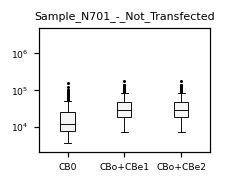

In [23]:
a = np.array(sc.obs.loc[list(correction_dict.keys())]["raw_cb_freq"])
b = np.array([sc.obs.loc[list(correction_dict.keys())[i]]["raw_cb_freq"] + sc.obs.loc[list(correction_dict.values())[i]]["raw_cb_freq"].sum() for i in range(len(correction_dict))])
c = np.array([sc.obs.loc[connected_components[i]]["raw_cb_freq"].sum() for i in range(len(connected_components)) if connected_components[i][0] in correction_dict.keys()])

plt.subplots(figsize = (2,1.5))
plt.boxplot([a,b,c], labels=["CB0", "CBo+CBe1", "CBo+CBe2"], widths = 0.25, patch_artist = True,\
                 boxprops={'facecolor': 'whitesmoke', 'color' : 'black', 'linewidth': 0.6},\
                 whiskerprops = {'linewidth': 0.6, 'color':'black'},\
                 capprops = {'linewidth': 0.6, 'color':'black'},\
                 medianprops = {'color' : 'black', 'linewidth' : 0.6},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'black', 'markeredgecolor':'black'})

plt.title(sample)
plt.yscale('log')
plt.ylim(2000,5e6)
plt.minorticks_off()
plt.savefig(f"./figs/percent_increase_lib_corr_{sample}.pdf")

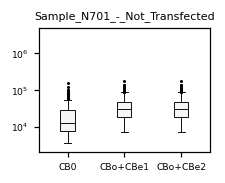

In [22]:
a = np.array(sc.obs.loc[list(correction_dict.keys())]["raw_cb_freq"])
b = np.array([sc.obs.loc[list(correction_dict.keys())[i]]["raw_cb_freq"] + sc.obs.loc[list(correction_dict.values())[i]]["raw_cb_freq"].sum() for i in range(len(correction_dict))])
c = np.array([sc.obs.loc[connected_components[i]]["raw_cb_freq"].sum() for i in range(len(connected_components)) if connected_components[i][0] in correction_dict.keys()])

plt.subplots(figsize = (2,1.5))
plt.boxplot([a,b,c], labels=["CB0", "CBo+CBe1", "CBo+CBe2"], widths = 0.25, patch_artist = True,\
                 boxprops={'facecolor': 'whitesmoke', 'color' : 'black', 'linewidth': 0.6},\
                 whiskerprops = {'linewidth': 0.6, 'color':'black'},\
                 capprops = {'linewidth': 0.6, 'color':'black'},\
                 medianprops = {'color' : 'black', 'linewidth' : 0.6},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'black', 'markeredgecolor':'black'})

plt.title(sample)
plt.yscale('log')
plt.ylim(2000,5e6)
plt.minorticks_off()
plt.savefig(f"./figs/percent_increase_lib_corr_{sample}.pdf")

In [23]:
np.mean((b-a)/a)

1.159727049530912

In [24]:
np.mean((c-b)/b)

0.01960180957035603

In [30]:
len(list(correction_dict.keys()))

344

In [31]:
len(np.concatenate(list(correction_dict.values())))

726

In [32]:
len(errors)

755

In [29]:
len(np.setdiff1d(errors, np.concatenate(list(correction_dict.values()))))

29

In [43]:
f = pd.read_csv(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/default/{sample}/alevin/raw_cb_frequency.txt", delimiter='\t', header = None)

In [295]:
k = pd.read_csv(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/default/{sample}/alevin/quants_mat_rows.txt", header=None)
w = pd.read_csv(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/default/{sample}/alevin/whitelist.txt", header=None)

In [49]:
import json
quant_params_default = "trimmed-reads-cutadapt-all/decoys-k31-1.4.0/default"
with open(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params_default}/{sample}/aux_info/alevin_meta_info.json") as f:
    data = json.load(f)

k = data["initial_whitelist"]
w = data["final_num_cbs"]

In [50]:
print(k,w)

900 785


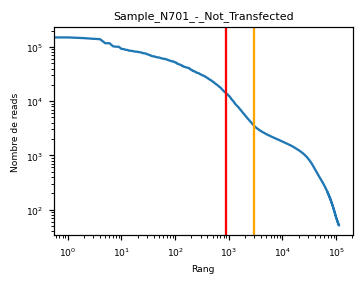

In [45]:
plt.subplots(figsize=(3.5,2.5))
plt.plot(f[1].values[f[1].values>50])
plt.yscale("log");
plt.xscale("log");
plt.axvline(3000, color="orange")
plt.axvline(k, color='red')
plt.title(sample)
plt.xlabel("Rang")
plt.ylabel("Nombre de reads")
plt.savefig(f"./figs/{prefix}_knee1.pdf")

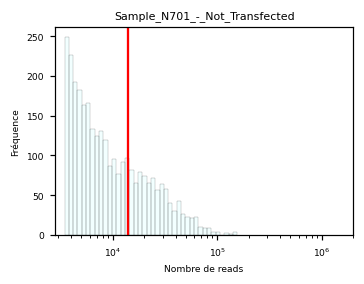

In [46]:
_,ax = plt.subplots(figsize=(3.5,2.5))
plt.axvline(f[1][k], color='red')
rnaseq.plotting.loghist(f[1].values[:3000], bins=40, ax=ax, linewidth=0.1, edgecolor='black', fc = (0.5,1,1,0.1));
plt.title(sample)
plt.xlim(2800,2e6)
plt.ylabel("Fréquence")
plt.xlabel("Nombre de reads")
plt.savefig(f"./figs/{prefix}_knee3.pdf");

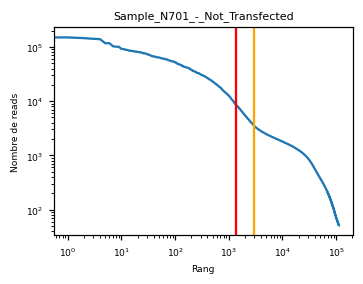

In [285]:
plt.subplots(figsize=(3.5,2.5))
plt.plot(f[1].values[f[1].values>50])
plt.yscale("log");
plt.xscale("log");
plt.axvline(3000, color="orange")
plt.axvline(len(k), color='red')
plt.title(sample)
plt.xlabel("Rang")
plt.ylabel("Nombre de reads")
plt.savefig(f"./figs/{prefix}_knee1.pdf")

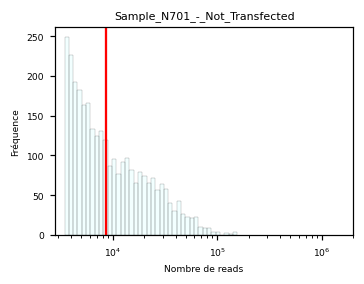

In [294]:
_,ax = plt.subplots(figsize=(3.5,2.5))
plt.axvline(f[1][len(k)], color='red')
rnaseq.plotting.loghist(f[1].values[:3000], bins=40, ax=ax, linewidth=0.1, edgecolor='black', fc = (0.5,1,1,0.1));
plt.title(sample)
plt.xlim(2800,2e6)
plt.ylabel("Fréquence")
plt.xlabel("Nombre de reads")
plt.savefig(f"./figs/{prefix}_knee3.pdf");

In [75]:
quant_params_new = "trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/customWh-top-3000-noWh"
sc_new = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params_new, genref = genref, cdna = "3' tag", exp = "sc")
rnaseq.setup.annotate_samples(sc_new, samples_annot_name = "total_UMIs", samples_annot = sc_new.X.toarray().sum(1).ravel())
rnaseq.setup.annotate_samples(sc_new, samples_annot_name = "max_corr", ow=True)

/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/customWh-top-3000-noWh
Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
Annotating total_UMIs...
Annotating max_corr...
Normalization by total UMIs...
Log2 + 1 tranformation...


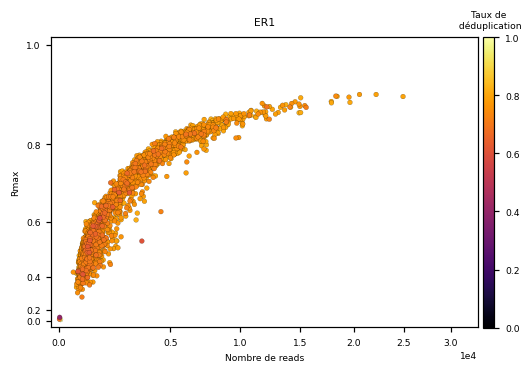

In [76]:
fig, ax = plt.subplots(figsize=(5,3.5))

color = "DedupRate"
lib_type = "total_UMIs"
# lib_type = "total_UMIs"

# cmap = "cividis"
cmap = "inferno"
norm = colors.TwoSlopeNorm(vmin=0., vcenter=.5, vmax=1)
s = 27

ax.set_yscale("square")
ax.set_xscale("squareroot")
ax.set_xlim(xmin =-100, xmax=33000)
ax.set_ylim(ymin=-0.15, ymax=1.015)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))



rnaseq.plotting.scatter(sc_new.obs[lib_type].values, sc_new.obs["max_corr"].values, sc_new.obs[color].values, \
            linewidth = 0.1, edgecolor = 'black', norm = norm, fig=fig, s = 10, \
            cmap = cmap, order_color = "descending", \
            color_title = "Taux de\n déduplication", xlabel = "Nombre de reads", ylabel = "Rmax", title = "ER1")    



plt.savefig(f"./figs/{prefix}_{lib_type}-max-corr_after-correction.pdf")

In [72]:
import json
quant_params = "trimmed-reads-cutadapt-all/decoys-k19-1.4.0/default"

with open(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/{project}/quant/alevin/{genref}/{quant_params}/{sample}/aux_info/alevin_meta_info.json") as f:
    alevin_meta_info = json.load(f)

knee = alevin_meta_info["initial_whitelist"]

In [73]:
np.sort(sc.obs["raw_cb_freq"])[::-1][knee]

13891

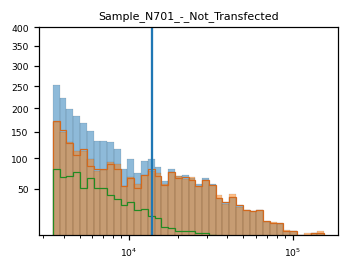

In [70]:
_,ax = plt.subplots(figsize=(3.5,2.5))
ax.set_title(sample)

# plt.xlim(3000,200000)
plt.ylim(1,400)
plt.yscale("squareroot")


tot = sc.obs["raw_cb_freq"]
logbins = rnaseq.plotting.loghist(tot, ax=ax, bins=40, lw = 0.1, edgecolor = "black", color = 'tab:blue', alpha = 0.5);

tot = sc_new.obs["raw_cb_freq"]
logbins = rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw = 0.1, edgecolor = "black", color = 'tab:orange', alpha = 0.5);

tot = sc.obs["raw_cb_freq"].loc[whitelist]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw=0.8, edgecolor = "chocolate",  histtype = "step");

tot = sc.obs["raw_cb_freq"].loc[errors]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw=0.8, edgecolor = "forestgreen",  histtype = "step",save_path = f"./figs/whitelist_res_hist_0_{sample}.pdf");

knee = sc.obs["raw_cb_freq"].values[np.argsort(sc.obs["raw_cb_freq"].values)][::-1][899]
plt.axvline(knee);

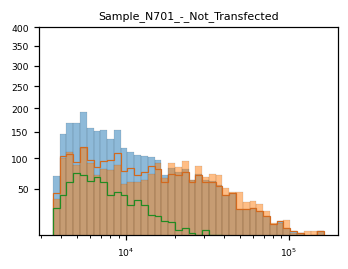

In [69]:
_,ax = plt.subplots(figsize=(3.5,2.5))
ax.set_title(sample)

# plt.xlim(3000,200000)
plt.ylim(1,400)
plt.yscale("squareroot")


tot = sc.obs["CorrectedReads"]
logbins = rnaseq.plotting.loghist(tot, ax=ax, bins=40, lw = 0.1, edgecolor = "black", color = 'tab:blue', alpha = 0.5);

tot = sc_new.obs["CorrectedReads"]
logbins = rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw = 0.1, edgecolor = "black", color = 'tab:orange', alpha = 0.5);

tot = sc.obs["CorrectedReads"].loc[whitelist]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw=0.8, edgecolor = "chocolate",  histtype = "step");

tot = sc.obs["CorrectedReads"].loc[errors]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw=0.8, edgecolor = "forestgreen",  histtype = "step",save_path = f"./figs/whitelist_res_hist_1_{sample}.pdf");

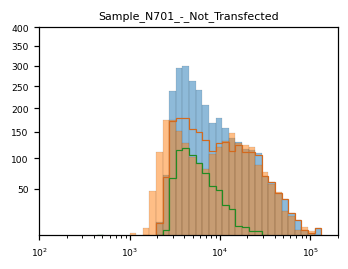

In [68]:
_,ax = plt.subplots(figsize=(3.5,2.5))
ax.set_title(sample)

plt.xlim(100,200000)
plt.ylim(1,400)
plt.yscale("squareroot")

tot = sc.obs["MappedReads"]
logbins = rnaseq.plotting.loghist(tot, ax=ax, bins=70, lw = 0.1, edgecolor = "black", color = 'tab:blue', alpha = 0.5);

tot = sc_new.obs["MappedReads"]
logbins = rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw = 0.1, edgecolor = "black", color = 'tab:orange', alpha = 0.5);

tot = sc.obs["MappedReads"].loc[whitelist]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw=0.8, edgecolor = "chocolate",  histtype = "step");

tot = sc.obs["MappedReads"].loc[errors]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw=0.8, edgecolor = "forestgreen",  histtype = "step",save_path = f"./figs/whitelist_res_hist_2_{sample}.pdf");

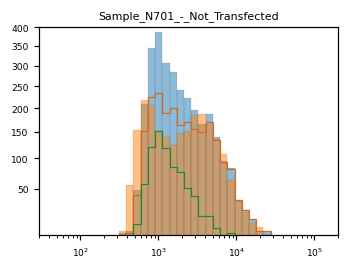

In [61]:
_,ax = plt.subplots(figsize=(3.5,2.5))
ax.set_title(sample)

plt.xlim(30,200000)
plt.ylim(1,400)
plt.yscale("squareroot")

tot = sc.obs["DeduplicatedReads"]
logbins = rnaseq.plotting.loghist(tot, ax=ax, bins=48, lw = 0.1, edgecolor = "black", color = 'tab:blue', alpha = 0.5);

tot = sc_new.obs["DeduplicatedReads"]
logbins = rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw = 0.1, edgecolor = "black", color = 'tab:orange', alpha = 0.5);

tot = sc.obs["DeduplicatedReads"].loc[whitelist]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw=0.8, edgecolor = "chocolate",  histtype = "step");

tot = sc.obs["DeduplicatedReads"].loc[errors]
rnaseq.plotting.loghist(tot, ax=ax, logbins=logbins, lw=0.8, edgecolor = "forestgreen",  histtype = "step",save_path = f"./figs/whitelist_res_hist_3_{sample}.pdf");